# 13. 심층신경망

## 13.3 Deep Binary Classification
### 1. 데이터 준비

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from copy import deepcopy

In [5]:
cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['class'] = cancer.target
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [6]:
# 넘파이 데이터를 파이토치 데이터로 변환후 크기 확인
data = torch.from_numpy(df.values).float()

x = data[:, :-1]
y = data[:, -1:]

print(x.shape, y.shape)

torch.Size([569, 30]) torch.Size([569, 1])


In [8]:
# data split 개수 정하기
ratios = [.6, .2, .2]

train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print(train_cnt, valid_cnt, test_cnt)

341 113 115


In [9]:
# data split
indices = torch.randperm(data.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = x.split(cnts, dim=0)
y = y.split(cnts, dim=0)

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([341, 30]) torch.Size([341, 1])
torch.Size([113, 30]) torch.Size([113, 1])
torch.Size([115, 30]) torch.Size([115, 1])


In [12]:
# 학습데이터만 스케일링 = x[0]
scaler = StandardScaler()
scaler.fit(x[0].numpy())

# transform은 모든 데이터 다 해주어야함
# scaling은 numpy로 수행하기 때문에 토치데이터로 다시 변환
x = [torch.from_numpy(scaler.transform(x[0].numpy())).float(),
     torch.from_numpy(scaler.transform(x[1].numpy())).float(),
     torch.from_numpy(scaler.transform(x[2].numpy())).float()]

### 2. 학습 코드 구현

In [16]:
# input features --> x[0].size(-1) = 30
# output features --> y[0].size(-1) = 1

model = nn.Sequential(nn.Linear(x[0].size(-1), 20),
                      nn.LeakyReLU(),
                      nn.Linear(20, 10),
                      nn.LeakyReLU(),
                      nn.Linear(10, y[0].size(-1)),
                      nn.Sigmoid())

optimizer = optim.Adam(model.parameters())

In [17]:
n_epochs = 10000
batch_size = 32
print_interval = 10
early_stop = 100

lowest_loss = np.inf
best_model = None
lowest_epoch = np.inf

In [21]:
train_history, valid_history = [], []

for i in range(n_epochs):
    
    # epoch을 반복할 때마다 datset shuffle
    indices = torch.randperm(x[0].size(0))
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    
    # train
    train_loss = 0
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += float(loss)
        
    train_loss = train_loss / len(x_)
    
    # valid
    valid_loss = 0
    
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = F.binary_cross_entropy(y_hat_i, y_i)
            
            valid_loss += float(loss)
            
    valid_loss = valid_loss / len(x_)
    
    # train_loss, valid_loss 기록
    train_history += [train_loss]
    valid_history += [valid_loss]
    
    # print
    if (i+1) % print_interval == 0:
        print(f'Epoch {i+1}/{n_epochs} Train Loss {train_loss:.6f} Valid Loss {valid_loss:.6f}')
    
    # 최저 loss
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        best_model = deepcopy(model.state_dict())
    else:
        if lowest_epoch + early_stop < i+1:
            print(f'There is no improvment during last {early_stop} epochs')
            break
    
print('----------Finish----------')
print(f'The best validation loss {lowest_loss:.6f} in {lowest_epoch+1}')
# model.load_state_dict(best_model)    

Epoch 10/10000 Train Loss 0.001067 Valid Loss 0.071021
Epoch 20/10000 Train Loss 0.000879 Valid Loss 0.072720
Epoch 30/10000 Train Loss 0.000761 Valid Loss 0.075056
Epoch 40/10000 Train Loss 0.000615 Valid Loss 0.076408
Epoch 50/10000 Train Loss 0.000511 Valid Loss 0.077758
Epoch 60/10000 Train Loss 0.000440 Valid Loss 0.079068
Epoch 70/10000 Train Loss 0.000382 Valid Loss 0.080392
Epoch 80/10000 Train Loss 0.000338 Valid Loss 0.081816
Epoch 90/10000 Train Loss 0.000292 Valid Loss 0.083320
Epoch 100/10000 Train Loss 0.000254 Valid Loss 0.084469
Epoch 110/10000 Train Loss 0.000223 Valid Loss 0.085099
Epoch 120/10000 Train Loss 0.000232 Valid Loss 0.086327
Epoch 130/10000 Train Loss 0.000189 Valid Loss 0.087492
Epoch 140/10000 Train Loss 0.000165 Valid Loss 0.088332
Epoch 150/10000 Train Loss 0.000144 Valid Loss 0.089264
There is no improvment during last 100 epochs
----------Finish----------
The best validation loss 0.036232 in 57


### 3. 손실 곡선 확인

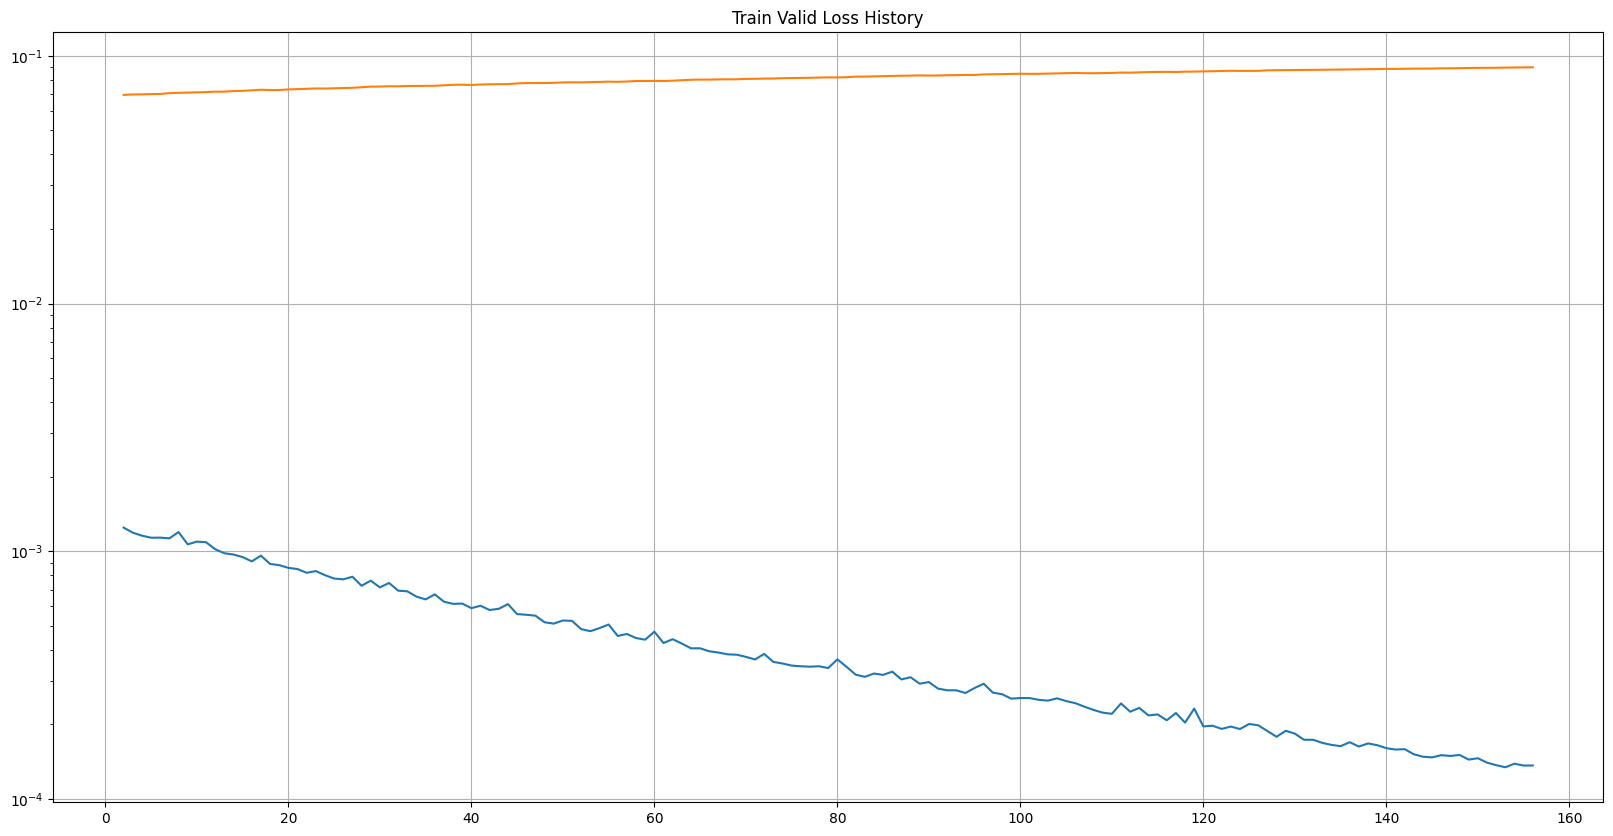

In [25]:
plot_form = 2

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title('Train Valid Loss History')
plt.plot(range(plot_form, len(train_history)), train_history[plot_form:],
         range(plot_form, len(valid_history)), valid_history[plot_form:],
        )
plt.yscale('log')
plt.show()

### 4. 결과 확인

In [26]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)
        
        test_loss += loss
        y_hat += [y_hat_i]
        
test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history), key = lambda x: x[1])

# sorted_history[0] : 제일 작은 loss
print('Train loss', sorted_history[0][0])
print('Valid loss', sorted_history[0][1])
print('Test loss', test_loss)

Train loss 0.0013207790166647596
Valid loss 0.0690820358347537
Test loss tensor(0.2280)


In [37]:
correct_cnt = (y[2] == (y_hat > .5)).sum()
total_cnt = float(y[2].size(0))
print('Test Accuracy', (correct_cnt/total_cnt))

Test Accuracy tensor(0.9739)


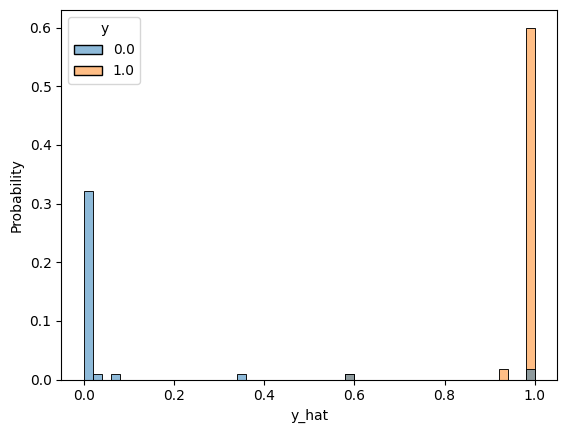

In [38]:
df = pd.DataFrame(torch.cat([y[2], y_hat], dim=1).detach().numpy(), columns=['y', 'y_hat'])
sns.histplot(df, x='y_hat', hue='y', bins=50, stat='probability')
plt.show()

In [40]:
roc_auc_score(df.values[:, 0], df.values[:, 1])

0.9909560723514212

## 13.7 MNIST
### 1. 데이터 준비
데이터경로: study/data  
- MNIST 샘플의 각 픽셀은 0~255 숫자로 이루어진 graysclae
- 하나의 샘플은 28x28 크기의 픽셀로 이루어져 있음

In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train = datasets.MNIST('../data/paper_review', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor()])
                      )
test = datasets.MNIST('../data/paper_review', train=False,
                      transform=transforms.Compose([transforms.ToTensor()])
                     )

100%|██████████| 9912422/9912422 [00:01<00:00, 5547447.48it/s]


Extracting ../data/paper_review/MNIST/raw/train-images-idx3-ubyte.gz to ../data/paper_review/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 1696126.99it/s]


Extracting ../data/paper_review/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/paper_review/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 2029699.76it/s]


Extracting ../data/paper_review/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/paper_review/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6698498.16it/s]

Extracting ../data/paper_review/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/paper_review/MNIST/raw



In [4]:
def plot(x):
    img = (np.array(x.detach().cpu(), dtype='float')).reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.show()

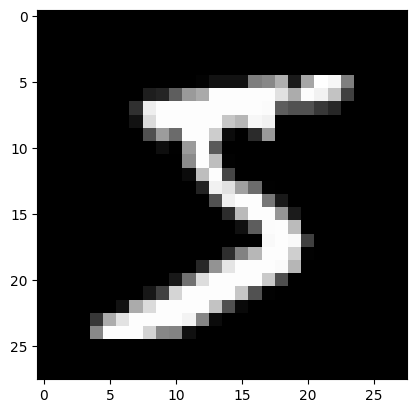

In [5]:
plot(train.data[0])

In [6]:
# 255로 나누어 0~1 사이 값으로 만들어주는 정규화
y = train.targets

x = train.data.float() / 255.
x = x.view(x.size(0), -1)    # 28x28이 flatten되어서 784
print(x.shape, y.shape)

torch.Size([60000, 784]) torch.Size([60000])


In [7]:
input_size = x.size(-1)
output_size = int(max(y)) + 1    # y는 다중 클래스로 0~9까지의 총 10개의 클래스가 있음
print(f'input_size {input_size}, output_size {output_size}')

input_size 784, output_size 10


In [8]:
# Train Valid Split
ratios = [.8, .2]

train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) * ratios[1])
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

print(train_cnt, valid_cnt, test_cnt)

indices = torch.randperm(x.size(0))
x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

x += [(test.data.float()/255.).view(test_cnt, -1)]
y += [test.targets]

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

48000 12000 10000
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


### 2. 학습 코드 구현

In [9]:
model = nn.Sequential(nn.Linear(input_size, 500),
                      nn.LeakyReLU(),
                      nn.Linear(500, 250),
                      nn.LeakyReLU(),
                      nn.Linear(250, 50),
                      nn.LeakyReLU(),
                      nn.Linear(50, output_size),
                      nn.LogSoftmax(dim=-1)
                     )

optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss()

In [10]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [11]:
model = model.to(device)

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

In [12]:
n_epochs = 1000
batch_size = 256

lowest_loss = np.inf
best_model = None
early_stop = 50
lowest_epoch = np.inf

In [15]:
train_history, valid_history = [], []
for epoch in range(n_epochs):
    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    # train
    train_loss = 0
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += float(loss)
    train_loss += train_loss / len(x)
    
    # valid
    valid_loss = 0
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())
            
            valid_loss += float(loss)
    valid_loss = valid_loss / len(x_)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
    
    if (epoch+1) % 20 == 0:
        print(f'Epochs {epoch+1}/{n_epochs} Train Loss {train_loss:.6f} Valid Loss {valid_loss:.6f}')
        
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = epoch
        best_model = deepcopy(model.state_dict())
    else:
        if lowest_epoch + early_stop < epoch+1:
            print(f'There is no improvement durint last {early_stop}')
            break
            
print('----------Finish----------')
print(f'The best validation loss is {lowest_loss} in {lowest_epoch+1}')
# model.load_state_dict(best_model)

Epochs 20/1000 Train Loss 0.000311 Valid Loss 0.116289
Epochs 40/1000 Train Loss 0.000043 Valid Loss 0.132155
There is no improvement durint last 50
----------Finish----------
The best validation loss is 0.07241958367856259 in 6


### 3. 손실 곡선 확인

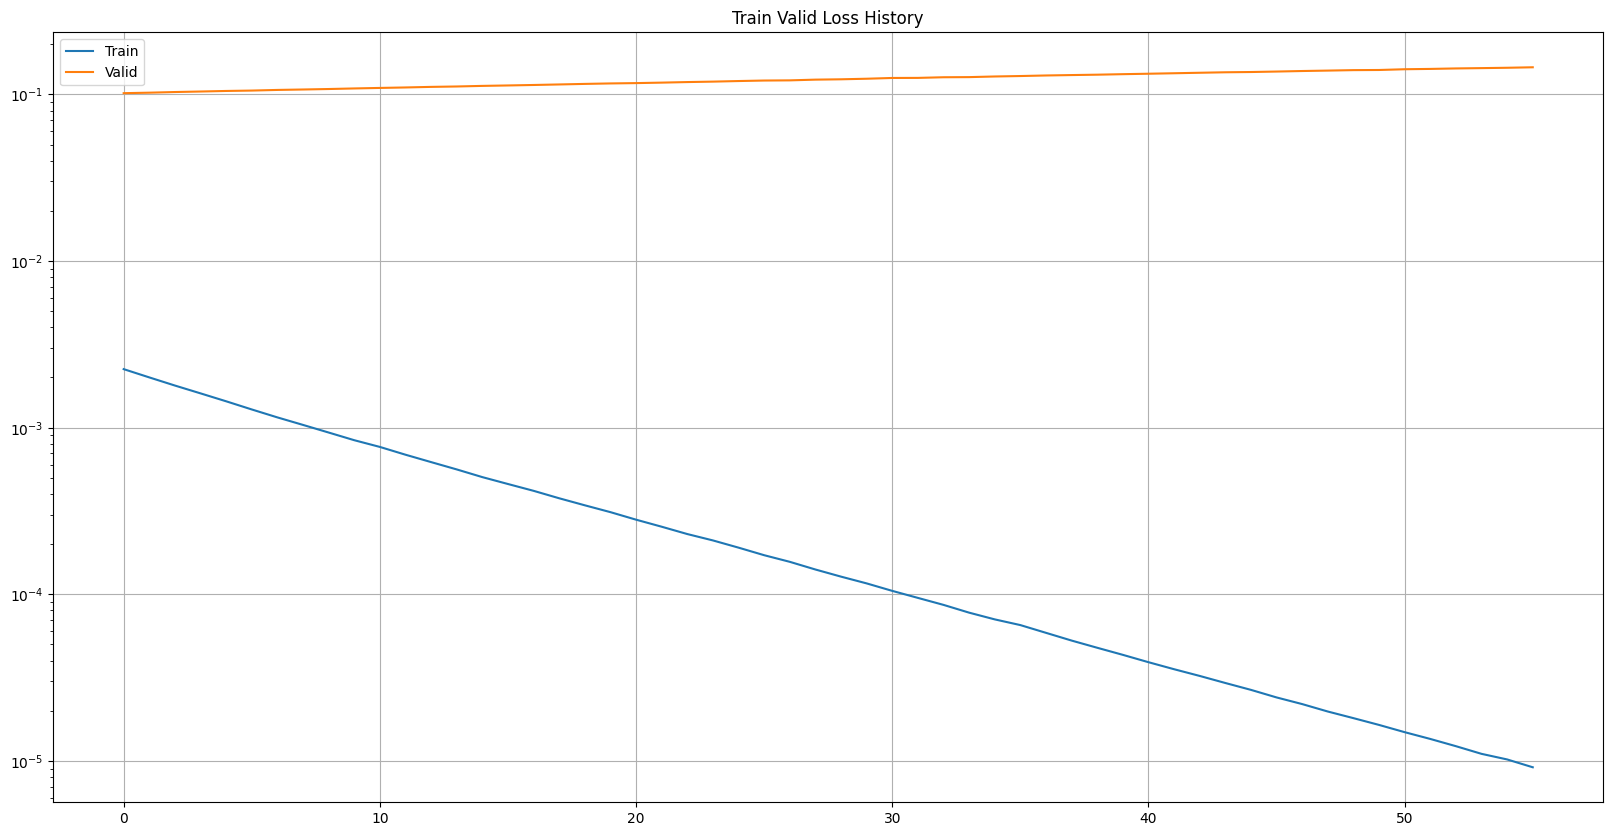

In [18]:
plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title('Train Valid Loss History')
plt.plot(train_history, label='Train')
plt.plot(valid_history, label='Valid')
plt.yscale('log')
plt.legend()
plt.show()

### 4. 결과 확인

In [19]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[-1].split(batch_size, dim=0)
    y_ = y[-1].split(batch_size, dim=0)
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i)
        
        test_loss += loss
        y_hat += [y_hat_i]
        
test_loss = test_loss/len(x_)
y_hat = torch.cat(y_hat, dim=0)
print('Test Loss ', test_loss)

Test Loss  tensor(0.1469, device='cuda:0')


In [29]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))
print('Test Accuracy', correct_cnt/total_cnt)

Test Accuracy tensor(0.9840, device='cuda:0')


In [38]:
pd.DataFrame(confusion_matrix(y[-1].cpu(), torch.argmax(y_hat.cpu(), dim=-1)),
             index=['true_%d' %i for i in range(10)],
             columns=['pred_%d' %i for i in range(10)]
            )

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,971,1,1,1,0,1,1,0,2,2
true_1,0,1126,2,0,0,1,2,0,4,0
true_2,4,1,1011,1,1,0,3,4,7,0
true_3,0,0,4,999,0,2,0,1,3,1
true_4,1,1,2,1,964,0,3,2,1,7
true_5,2,0,0,6,1,877,1,0,4,1
true_6,2,2,0,1,2,4,945,0,2,0
true_7,1,1,6,2,1,0,0,1007,2,8
true_8,1,1,4,3,3,3,1,3,952,3
true_9,2,2,0,4,8,1,0,2,2,988
